In [1]:
%pip install pandas -q
%pip install matplotlib -q
%pip install kagglehub -q
%pip install tensorflow -q
%pip install scikit-learn -q
%pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPool2D, GlobalAveragePooling2D, Dropout, BatchNormalization 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import preprocess_input

from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 42
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
    
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

2025-07-31 10:42:45.021163: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-31 10:42:45.033493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753947765.045959   30211 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753947765.049519   30211 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753947765.060837   30211 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# загрузим данные
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")


In [4]:
# преднастройка формаирование датасета
settings_loading_data = dict(
    labels='inferred',
    label_mode='binary',
    color_mode='grayscale',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED
)

In [5]:
# сформируем датасеты
df_train = image_dataset_from_directory(
    path + '/chest_xray/train',
    shuffle=True,
    **settings_loading_data
)

df_valid = image_dataset_from_directory(
    path + '/chest_xray/val',
    shuffle=False,
    **settings_loading_data
)

df_test = image_dataset_from_directory(
    path + '/chest_xray/test',
    shuffle=False,
    **settings_loading_data
)

Found 5216 files belonging to 2 classes.


I0000 00:00:1753947767.879522   30211 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5529 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [6]:
# вывод 9 фотографий из датасета для примера
class_names = df_train.class_names
print("Классы:", class_names)

# for images, labels in df_train.take(1):
#     plt.figure(figsize=(10, 10))
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8").squeeze(), cmap='gray') 
#         plt.title(f"Class: {class_names[int(labels[i].numpy().item())]}")
#         plt.axis("off")
#     plt.show()

Классы: ['NORMAL', 'PNEUMONIA']


In [7]:
# т.к. 16 изображений валидационной выборки - это очень мало, то объединим test с val, а потом разобьем их
df_train_full = df_train.concatenate(df_valid)
val_size = int(len(df_train_full) * 0.2)

df_valid = df_train_full.take(val_size)
df_train = df_train_full.skip(val_size)

print(f"Новый размер train (батчей): {len(df_train)}")
print(f"Новый размер valid (батчей): {len(df_valid)}")

Новый размер train (батчей): 132
Новый размер valid (батчей): 32


In [8]:
# проверим баланс классов
# TODO - сделать попроще это ячейку
labels = []
for _, label_batch in df_train:
    labels.extend(label_batch.numpy())

normal_count = np.sum(np.array(labels) == 0)
pneumonia_count = np.sum(np.array(labels) == 1)

print(f"Класс NORMAL (0): {normal_count} изображений")
print(f"Класс PNEUMONIA (1): {pneumonia_count} изображений")

Класс NORMAL (0): 1069 изображений
Класс PNEUMONIA (1): 3139 изображений


2025-07-31 10:42:50.773149: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# настроим аугментацию
# 1. будем поворачивать фотографии, на 10 градусов в разные стороны
# 2. смещаем фотографии по вертикали и горизонатли на 10 процентов
# 3. зумим фотографии на 20 процентов
data_augmentation_pipeline = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=10/360.0, fill_mode="nearest", interpolation="bilinear"),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="nearest", interpolation="bilinear"),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest", interpolation="bilinear")
])

In [10]:
# Функция для нормализации
def normalize_img(image, label):
    """Приводит значения пикселей к диапазону [0, 1]."""
    return tf.cast(image, tf.float32) / 255.0, label

# Функция аугментации и нормализации для ТРЕНИРОВОЧНЫХ данных
def augment_and_normalize_train(image, label):
    """Применяет аугментацию и затем нормализует изображение."""
    image_augmented = data_augmentation_pipeline(image, training=True)
    return tf.cast(image_augmented, tf.float32) / 255.0, label

# Применяем новые функции к нашим датасетам
# Важно: аугментацию применяем ТОЛЬКО к df_train
df_train_processed = df_train.map(augment_and_normalize_train, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
df_valid_processed = df_valid.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
df_test_processed = df_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [11]:
# проверим баланс классов
# TODO - сделать попроще это ячейку
labels = []
for _, label_batch in df_train_processed:
    labels.extend(label_batch.numpy())

normal_count = np.sum(np.array(labels) == 0)
pneumonia_count = np.sum(np.array(labels) == 1)

print(f"Класс NORMAL (0): {normal_count} изображений")
print(f"Класс PNEUMONIA (1): {pneumonia_count} изображений")

Класс NORMAL (0): 1073 изображений
Класс PNEUMONIA (1): 3135 изображений


2025-07-31 10:42:54.342693: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
# рассчитаем class_weights
# сделаем это через кол-во элементов одного и второго класса
labels = np.concatenate([y for x, y in df_train_processed], axis=0)
normal_count = np.sum(labels == 0)
pneumonia_count = np.sum(labels == 1)
total_count = len(labels)

weight_for_0 = (1 / normal_count) * (total_count / 2)
weight_for_1 = (1 / pneumonia_count) * (total_count / 2)

class_weights = {0: weight_for_0, 1: weight_for_1}

In [13]:
# создадим модель
model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(learning_rate=1e-3), 
    metrics=[
        'accuracy',       
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)
model.summary()

/home/koziy/projects/xray_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    51,381,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,776,129 (197.51 MB)

 Trainable params: 51,773,121 (197.50 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [14]:
# используем коллбэки
# 1. Настройка learning rate при обучении
# 2. Сохранение лучшей версии модели
# 3. Остановка обучения, если нет улучшений
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    df_train_processed,
    validation_data=df_valid_processed,
    class_weight=class_weights,
    epochs=30,
    callbacks=[reduce_lr, model_checkpoint, early_stopping]
)

Epoch 1/30


I0000 00:00:1753947781.469458   30411 service.cc:152] XLA service 0x7d4d5c006930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753947781.469483   30411 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-07-31 10:43:01.591714: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753947782.000312   30411 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/132 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.5391 - auc: 0.5599 - loss: 1.7751 - precision: 0.7252 - recall: 0.5565  

I0000 00:00:1753947788.283273   30411 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8116 - auc: 0.9035 - loss: 0.6420 - precision: 0.9547 - recall: 0.7804

132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 129ms/step - accuracy: 0.8119 - auc: 0.9038 - loss: 0.6400 - precision: 0.9549 - recall: 0.7808 - val_accuracy: 0.7246 - val_auc: 0.6957 - val_loss: 0.9485 - val_precision: 0.7432 - val_recall: 0.9519 - learning_rate: 0.0010
Epoch 2/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.9100 - auc: 0.9719 - loss: 0.2164 - precision: 0.9765 - recall: 0.9012 - val_accuracy: 0.7256 - val_auc: 0.5000 - val_loss: 3.3903 - val_precision: 0.7256 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/30
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8923 - auc: 0.9638 - loss: 0.2515 - precision: 0.9691 - recall: 0.8813
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.8926 - auc: 0.9639 - loss: 0.2510 - precision: 0.9691 - recall: 0.8817 - val_accuracy: 0.7285 - val_auc: 0.5000 - val_loss: 3.3726 - val_precision: 0.7285 - val_recall: 1.0000 - learning_rate: 0.0010
Ep

132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.9318 - auc: 0.9848 - loss: 0.1555 - precision: 0.9842 - recall: 0.9232 - val_accuracy: 0.7383 - val_auc: 0.9131 - val_loss: 0.8716 - val_precision: 0.7361 - val_recall: 0.9973 - learning_rate: 2.0000e-04
Epoch 5/30
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9380 - auc: 0.9859 - loss: 0.1502 - precision: 0.9821 - recall: 0.9336

132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.9380 - auc: 0.9859 - loss: 0.1504 - precision: 0.9821 - recall: 0.9336 - val_accuracy: 0.9512 - val_auc: 0.9899 - val_loss: 0.1349 - val_precision: 0.9873 - val_recall: 0.9447 - learning_rate: 2.0000e-04
Epoch 6/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9420 - auc: 0.9877 - loss: 0.1382 - precision: 0.9833 - recall: 0.9378 - val_accuracy: 0.9424 - val_auc: 0.9931 - val_loss: 0.1858 - val_precision: 0.9957 - val_recall: 0.9252 - learning_rate: 2.0000e-04
Epoch 7/30
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9421 - auc: 0.9880 - loss: 0.1375 - precision: 0.9868 - recall: 0.9344
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9421 - auc: 0.9880 - loss: 0.1376 - precision: 0.9868 - recall: 0.9344 - val_accuracy: 0.9111 - val_auc: 0.9905 - val_loss: 0.2657 - val_precision: 0.9970 - val_recall: 0.8820 - learning_rate: 2.

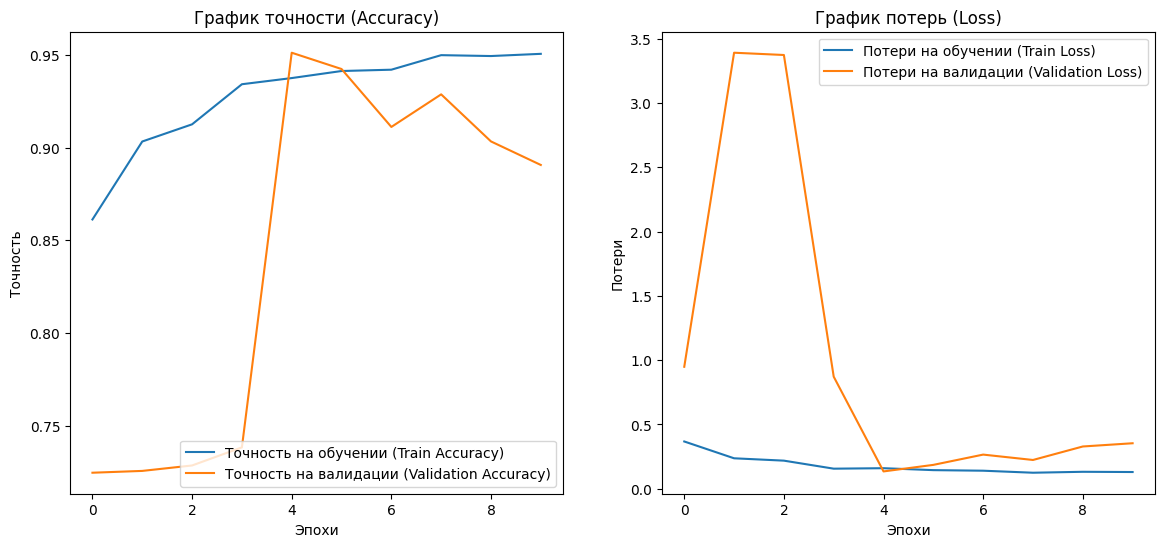

In [15]:
# --- НОВАЯ ЯЧЕЙКА: Визуализация результатов обучения ---

# history - это объект, который вернул model.fit()
# history.history - это словарь с записями метрик по эпохам

# Извлекаем данные из истории обучения
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Создаем массив эпох для оси X
epochs_range = range(len(acc))

# Создаем фигуру для графиков
plt.figure(figsize=(14, 6))

# --- График точности (Accuracy) ---
plt.subplot(1, 2, 1) # 1 строка, 2 колонки, 1-й график
plt.plot(epochs_range, acc, label='Точность на обучении (Train Accuracy)')
plt.plot(epochs_range, val_acc, label='Точность на валидации (Validation Accuracy)')
plt.legend(loc='lower right')
plt.title('График точности (Accuracy)')
plt.xlabel('Эпохи')
plt.ylabel('Точность')

# --- График потерь (Loss) ---
plt.subplot(1, 2, 2) # 1 строка, 2 колонки, 2-й график
plt.plot(epochs_range, loss, label='Потери на обучении (Train Loss)')
plt.plot(epochs_range, val_loss, label='Потери на валидации (Validation Loss)')
plt.legend(loc='upper right')
plt.title('График потерь (Loss)')
plt.xlabel('Эпохи')
plt.ylabel('Потери')

# Показываем графики
plt.show()

In [16]:
# проверим модель на тесте
results = model.evaluate(df_test_processed)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.8147 - auc: 0.6261 - loss: 0.6712 - precision: 0.4672 - recall: 0.6577    
Test Loss: 0.4242215156555176
Test Accuracy: 0.8814102411270142


___
    ДО class_weights:
    Test Loss: 0.6504877805709839
    Test Accuracy: 0.6089743375778198

    ПОСЛЕ class_weights:
    Test Loss: 0.6858784556388855
    Test Accuracy: 0.6330128312110901

    Test Loss: 0.4242215156555176
    Test Accuracy: 0.8814102411270142
___

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


2025-07-31 10:45:03.929245: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


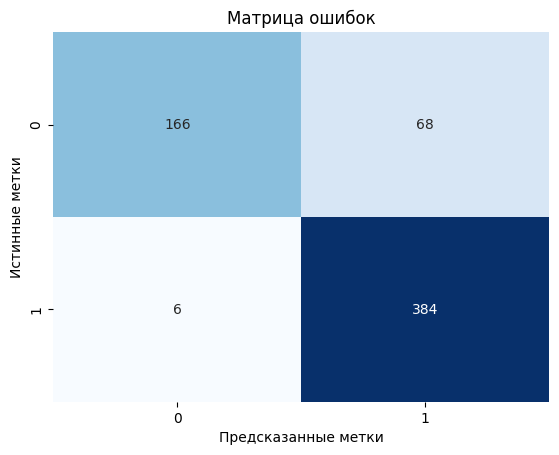

              precision    recall  f1-score   support

      NORMAL       0.97      0.71      0.82       234
   PNEUMONIA       0.85      0.98      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.85      0.86       624
weighted avg       0.89      0.88      0.88       624



In [17]:
# сделаем матрицу ошибок
y_pred_proba = model.predict(df_test_processed)
y_pred = (y_pred_proba > 0.5).astype('int32')
y_true = np.concatenate([y for x, y in df_test_processed], axis=0)


cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))